# Inference problem on Hilbert Model space

In [28]:
import numpy as np
from pygeoinf import linalg
import scipy.integrate as spi
from scipy.special import legendre
from sola.main_classes import functions, domains
from sola.aux import predefined_functions
import matplotlib.pyplot as plt

## Define spaces and mappings

### Define D and P

In [50]:
# Define the data and property spaces
D_dim = 5
P_dim = 1

D = linalg.EuclideanSpace(D_dim)
P = linalg.EuclideanSpace(P_dim)

### Define M

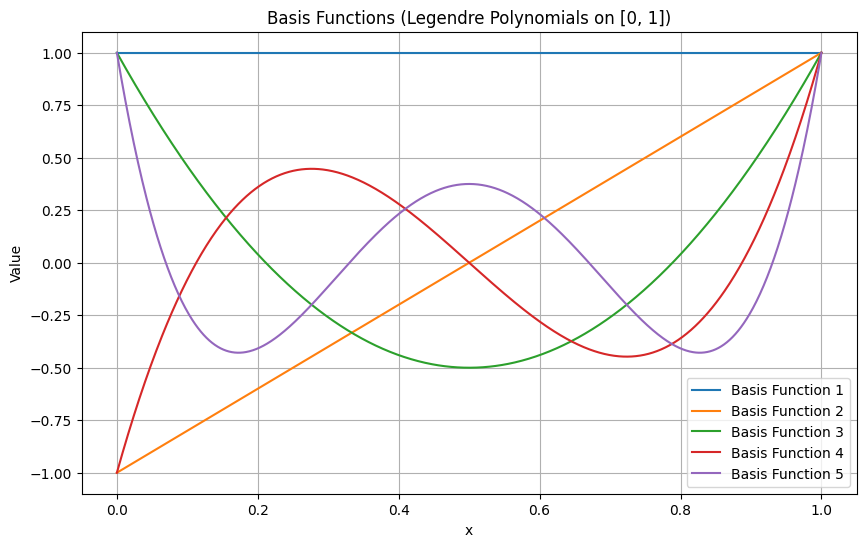

In [51]:
%matplotlib inline
# Define Model space

# Discretization of the model space
M_dim = 5

# Define the basis functions (Legendre polynomials on [0,1])
domain = domains.HyperParalelipiped([[0, 1]])
basis_functions_evaluation = [
    lambda x, n=n: legendre(n)(2 * x - 1)
    for n in range(M_dim)
]
basis_functions = [
    functions.Function(
        domain,
        evaluate_callable=basis_function
    )
    for basis_function in basis_functions_evaluation
]

# Plot the basis functions

# Evaluate each basis function on the domain
plt.figure(figsize=(10, 6))
for i, basis_function in enumerate(basis_functions):
    plt.plot(domain.mesh, basis_function.evaluate(domain.mesh), label=f"Basis Function {i+1}")

# Add labels, title, and legend
plt.title("Basis Functions (Legendre Polynomials on [0, 1])")
plt.xlabel("x")
plt.ylabel("Value")
plt.legend()
plt.grid()
plt.show()

In [52]:
# Define the inner product on the model space
def M_inner_product(f: functions.Function, g: functions.Function):
    return spi.quad(
        lambda x: f.evaluate(x) * g.evaluate(x),
        f.domain.bounds[0][0],
        f.domain.bounds[0][1]
    )[0]

# Convert function to coefficients (projection onto basis)
def M_to_components(f: functions.Function, basis_functions):
    return [
        M_inner_product(f, basis_function)
        for basis_function in basis_functions
    ]

# Convert coefficients back to function (linear combination)
def M_from_components(c, M_dim):
    function_evaluation = lambda x: sum(
        c[i] * basis_functions[i].evaluate(x)
        for i in range(M_dim)
    )
    return functions.Function(
        domain,
        evaluate_callable=function_evaluation
    )

M = linalg.HilbertSpace(M_dim, lambda f: M_to_components(f, basis_functions),
                        lambda c: M_from_components(c, M_dim),
                        M_inner_product)

### Define G

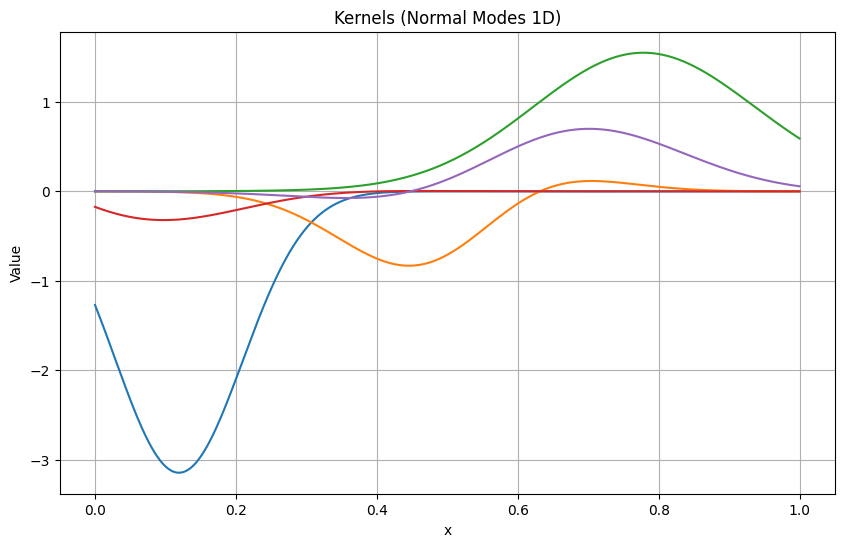

In [53]:
# Define G mapping
kernels = [
    predefined_functions.NormalModes_1D(
        domain, order=10, spread=0.1, max_freq=10
    ) for _ in range(D_dim)
]

# Plot all the kernels
plt.figure(figsize=(10, 6))

for i, kernel in enumerate(kernels):
    y = kernel.evaluate(domain.mesh)  # Evaluate the kernel on the domain's mesh
    plt.plot(domain.mesh, y, label=f"Kernel {i+1}")

# Add labels, title, and legend
plt.title("Kernels (Normal Modes 1D)")
plt.xlabel("x")
plt.ylabel("Value")
plt.grid()
plt.show()

In [54]:
# Define the G mapping function
# This function maps a function `f` in the model space to a vector in the data space
# by computing the inner product of `f` with each kernel in the `kernels` list.
def G_mapping(f: functions.Function, kernels):
    return np.array([M.inner_product(f, kernel) for kernel in kernels])

# Define the linear operator G
# This operator maps from the model space (M) to the data space (D) using the G_mapping function.
G = linalg.LinearOperator(M, D, lambda f: G_mapping(f, kernels))

### Define T

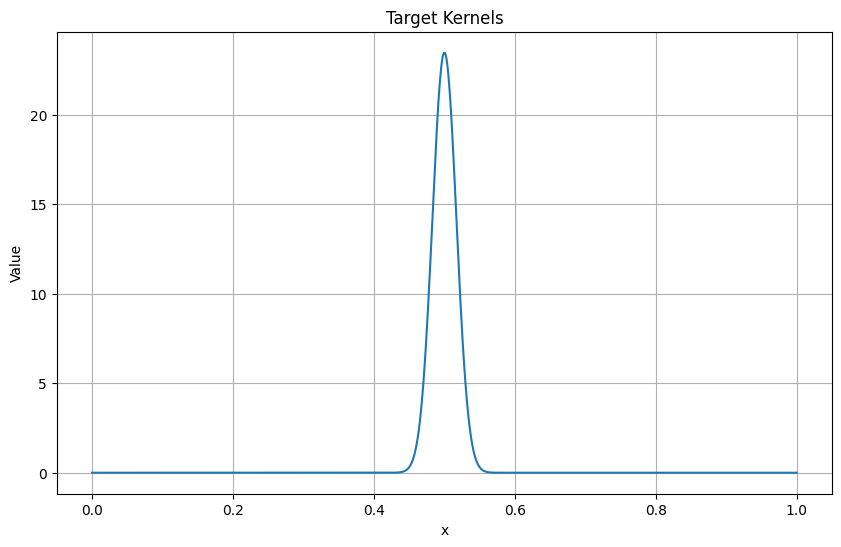

In [55]:
# Define G mapping
targets = [
    predefined_functions.Gaussian_1D(domain, center=0.5, width=0.1)
    for i in range(P_dim)
]

# Plot all the kernels
plt.figure(figsize=(10, 6))

for i, target in enumerate(targets):
    y = target.evaluate(domain.mesh)  # Evaluate the kernel on the domain's mesh
    plt.plot(domain.mesh, y, label=f"Kernel {i+1}")

# Add labels, title, and legend
plt.title("Target Kernels")
plt.xlabel("x")
plt.ylabel("Value")
plt.grid()
plt.show()

In [56]:
# Define the T mapping function
# This function maps a function `f` in the model space to a vector in the property space
# by computing the inner product of `f` with each target in the `targets` list.
def T_mapping(f: functions.Function, targets):
    return np.array([M.inner_product(f, target) for target in targets])

# Define the linear operator T
# This operator maps from the model space (M) to the property space (P) using the T_mapping function.
T = linalg.LinearOperator(M, P, lambda f: T_mapping(f, targets))

## Find least norm solution

In [57]:
# Step 1: Compute GG^*
GG_star = G @ G.adjoint

# Step 2: Compute (GG^*)^-1 using a solver
solver = linalg.CGSolver(rtol=1e-8, atol=1e-10, maxiter=1000)  # Conjugate Gradient Solver
GG_star_inverse = solver(GG_star)

# Step 3: Compose G^* with (GG^*)^-1
G_star_GG_star_inverse = G.adjoint @ GG_star_inverse

# Print the resulting operator
print("Operator G^* (GG^*)^-1 computed successfully.")

Operator G^* (GG^*)^-1 computed successfully.


### Create fake model and data

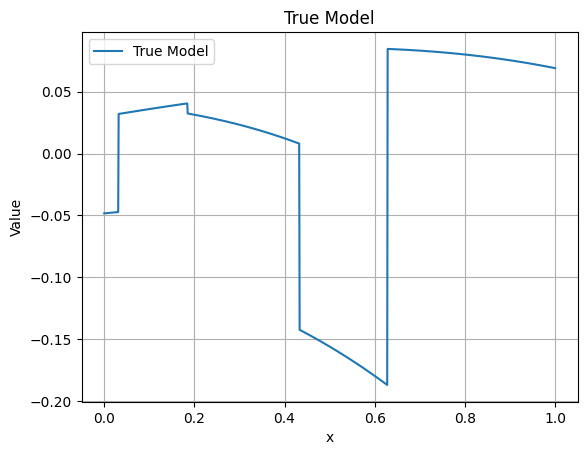

/tmp/ipykernel_1547/136972800.py:3: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return spi.quad(


In [58]:
# Fake Model
m_true = predefined_functions.Random_1D(domain, seed=44)

plt.plot(domain.mesh, m_true.evaluate(domain.mesh), label="True Model")
plt.title("True Model")
plt.xlabel("x")
plt.ylabel("Value")
plt.grid()
plt.legend()
plt.show()

# Fake data
d = G(m_true)

In [61]:
# Find least norm solution
solution = G_star_GG_star_inverse(d)

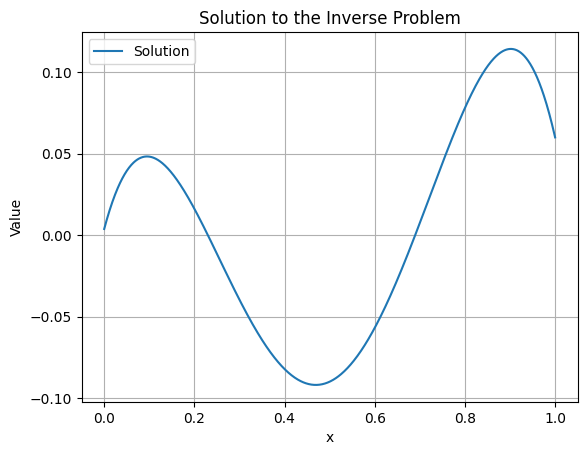

In [60]:
plt.plot(domain.mesh, solution.evaluate(domain.mesh), label="Solution")
plt.title("Solution to the Inverse Problem")
plt.xlabel("x")
plt.ylabel("Value")
plt.legend()
plt.grid()
plt.show()